# Project 1: Pose Graph Optimization (scratch + g2o)
TEAM-ID: 14   
TEAM-NAME: bb8       
YOUR-ID: 2018101012     
YOUR-NAME: Jaidev Shriram

(Although you work in groups, both the students have to submit to Moodle, hence there's name field above)

### Submission
Zip a folder of the following:
1. Files that you were provided with: `Project-1.ipynb`, the folders `misc` and `dataset`. Rest of the files asked in the questions below must be generated when i run the code. If generation of any file is computationally intensive, add `filename_backup.extension` where `filename.extension` is the expected name of file when i run the code. (For example, next point.)
2. Add `opt_backup.g2o` (described below) in outermost directory. Here, `opt.g2o` is the expected name of the file when I run the code.
3. For images of any results (like plots), save it in `./misc` folder.

On Moodle, all you have to submit is the jupyter notebook. But make sure to call the necessary functions explicitly (as specified in the notebook). The name of the zipped file being submitted to Moodle Assignment portal MUST BE `ID_Teamname_Firstname`. More details [here](https://www.notion.so/saishubodh/Course-Information-4c9e487b118547b2ba91d24e0dcaf04e#f2707a04f2a0446bac77763b47ba4bac).

On GitHub classrooms, the latest commit before the deadline will be considered as the submission. 

The deadline is Oct 16, 23:55 IST. Please get started ASAP, there is no way you can finish this project during the last few days before the deadline.

### General instructions

This ipython notebook (`.ipynb`) on GitHub is self-sufficient and has all the information you need to get started with the assignment, you don't need any corresponding PDF doc. Just fire up the notebook and get going!

General information like installation instructions in supplementary notebook "Project-1_Code-Walkthrough". Please take a look at it before you start this assignment.

Whenever I mention some `func()` below, I am referring to the "helper functions" in another supplementary notebook "Project-1_Code-Walkthrough" provided to you. Whenever I ask you to insert image below, it is better to save the image in `misc` and load it using `![file_name](file_location)` instead of directly pasting.    

[[CP-]] refers to CheckPoint, you have to ensure you do the tasks at each of the [[CP-]] places below. Not ensuring [[CP-B]] (CheckPoint-Basic) will incur heavy penalty and potentially 0 for that sub-section, and [[CP-M]] (CheckPoint-Marks) has a particular mark weightage depending on your results at that particular CP.

If you face any issues related to coding/installation, please raise an [issue here](https://github.com/Shubodh/MR-project1-pgo/issues). For any conceptual doubts, you can ask on Moodle or Teams as usual.

# 0. Introduction

In this project, we are going to use a non-linear weighted least squares optimization approach to solve the problem of getting a better estimate of our robot's trajectory. Least squares formulations are widely used for optimization, be it computer vision or robotics or machine learning. We will dive deep into it during this project and you will have complete clarity on optimization for vector-valued residual functions. 

In this "Introduction" section, I am going to provide an introduction for SLAM problem for a robot operating in the 2D world. It is 2. section in this Project. The 1D SLAM problem (1.) is far much simpler to understand and will be described directly in the 1. section. 

In a 2D world, a robot has 3 degrees of freedom, i.e. its pose in the world can be expressed by the state vector $\mathbf{x}=(x, y, \theta)^{\mathrm{T}}$. For the scope of this project, we are interested only in the robot's trajectory through the $2 \mathrm{D}$ world, and NOT in distinct landmarks or the surronding map of the environment, i.e. we are only interested in "L"ocalization part of SLAM. 

Therefore, we can represent it as a graph where the vertices represent robot poses $\mathbf{x}_{i}$ and edges represent the spatial constraints between these poses. Such a map is generally called a pose graph.

Two different kinds of constraints are necessary for pose graph SLAM. The first are
odometric constraints that connect two successive states $\mathbf{x}_{i}$ and $\mathbf{x}_{i+1}$ via a motion model. Furthermore, in order to perform loop closing, the robot has to recognize places it already visited before. This place recognition is also a part of the front-end and provides the second type of constraint, the loop closure constraints. These constraints connect two not necessarily successive poses $\mathbf{x}_{i}$ and $\mathbf{x}_{j}$.


![SLAM-trajectory-lc.png](misc/SLAM-trajectory-lc.png)   ![SLAM-trajectory-robust.png](misc/SLAM-trajectory-robust.png) (Source: [Sunderhauf 2012](https://core.ac.uk/download/pdf/89299995.pdf))

You will start from the inaccurate pose graph with odometry and loop closure information and by the end of this Project, you end up with an optimized pose graph (see above images) which should look close to ground truth trajectory. You can watch [this video](https://youtu.be/saVZtgPyyJQ) to get an intuition for what we're about to do.

Okay, that's enough of theory. Let's get out hands dirty with the code!

In [1]:
import matplotlib.pyplot as plt
import math
import os
import jax
import jax.numpy as jnp #see supplementary notebook to see how to use this
from jax import jacfwd

# import numpy as np
# If you're `importing numpy as np` for debugging purposes, 
# while submitting, please remove 'import numpy' and replace all np's with jnp's.(more in supplementary notebook)

# 1. Pose Graph Optimization for 1D SLAM

A solved example for 1D SLAM which optimizes for pose variables using weighted least squares method (Gauss Newton) has been explained in the class. It has been made [available here](https://www.notion.so/saishubodh/Solved-Example-1D-SLAM-weighted-LS-Illustrating-Sparsity-in-SLAM-d8b45893843b4377b07b1d4aa1aab4de). Your first task is to code this from scratch. [[CP-M]]

For this section, you have to calculate Jacobian analytically yourself and use it. However, you can check how correct `jax`'s `jacobian`. Its usage is explained in the supplementary notebook.

/Users/ahish/lib/python3.6/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


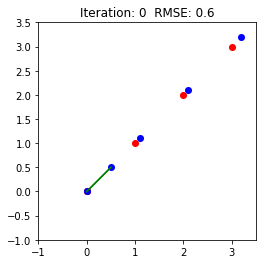

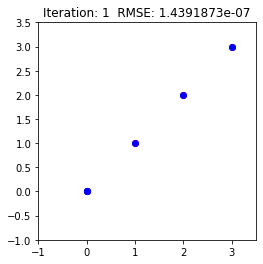

Optimized poses: [0. 1. 2. 3. 0.]


In [2]:
##############################################################################
# TODO: Code for Section 1                                                   #

"""
    Generates the following data points:
    - origin: The origin of the graph
    - x: 1D array with the positions of robot at time i (index i) (pre correction)
    - u: Odometry information representing the expected change in pose at instant i
    - var: Amount of noise in the poses, or inverse of confidence 
"""
def get_1d_data():
    origin = 0
    x = jnp.array([0, 1.1, 2.1, 3.2, 0.5])
    u = jnp.array([1, 1, 1, -3])
    var = jnp.array([0.01, 0.01, 0.01, 0.01, 0.01])
    return x, u, var, origin

"""
    Generates the loop closure constraints as follows:
    - mapping: 2D array with each row representing loop between points in column 1 and column 2
"""
def loop_closure_data():
    mapping = jnp.array([[0, 4]])
    return mapping

"""
    Returns the jacobian deriving from the odometry constraints. It is used
    to form the larger jacobian with the other constraints.
"""
def get_jacobian_x(f, x, indices):
    J = [[ 1 if i == j else (-1 if j == i+1 else 0)  for j in range(indices.shape[0]) ] for i in range(indices.shape[0]-1)]
    return jnp.array(J)

"""
    Returns the jacobian deriving from the loop closure constraints. It is used
    to form the larger jacobian with other constraints.
"""
def get_jacobian_loop(f, constraints, indices):
    J = [[ 1 if constraints[j][0] == i else (-1 if constraints[j][1] == i else 0) for i in range(indices.shape[0]) ] for j in range(f.shape[0])]
    return jnp.array(J)    
   
"""
    Returns the jacobian deriving from the origin constraint. It is used
    to form the larger jacobian with other constraints.
"""
def get_jacobian_origin(origin, indices):
    J = jnp.zeros(indices.shape[0])
    J = jax.ops.index_update(J, origin, 1)
    return jnp.array([J])
   
"""
    Returns the jacobian with respect to all the poses using the functions 
    defined above.
"""
def ret_jacobian(x, u, mapping, origin):

    # Here, f is the residue
    f = x[:-1] + u - x[1:]
    J_x = get_jacobian_x(f, x, jnp.linspace(0, u.shape[0]+1, u.shape[0]+1))
    
    f_loop = x[mapping[:, 0]] + jnp.zeros(len(mapping[:, 1])) - x[mapping[:, 1]]
    f = jnp.append(f, f_loop)
    J_loop = get_jacobian_loop(f_loop, mapping, jnp.linspace(0, u.shape[0]+1, u.shape[0]+1))
    
    f_o = x[origin]
    f = jnp.append(f, f_o)
    J_o = get_jacobian_origin(origin, jnp.linspace(0, u.shape[0]+1, u.shape[0]+1))
       
    J = jnp.vstack((J_x, J_loop, J_o))

    return J

"""
    Visualizing Loop closure constraints - uses the code provided in assignment-3
    It plots 1D data on a 2D graph by using the same values on each axis
"""
def plot_trajectory(X, P0, mapping, i, rmse):
    plt.cla()
    plt.scatter(P0[0,:], P0[1,:], c='r', marker='o', s=50, lw=0)
    plt.scatter(X[0,:], X[1,:], c='b', marker='o', s=50, lw=0)

    temp = X[0, mapping[0]].reshape(-1, 1)
    temp = jnp.append(temp, temp, axis=1)
    
    plt.plot(temp, temp, c='g')
    plt.title("Iteration: " + str(i) + "  RMSE: " + str(rmse))
    plt.axis([-1, 3.5, -1, 3.5])
    plt.gca().set_aspect('equal', adjustable='box')
    plt.draw()
    plt.pause(2)

    return

"""
    A modified version of the gauss newton algorithm using the information matrix.
    
    Inputs:
    - origin: The origin of the graph
    - x: 1D array with the positions of robot at time i (index i) (pre correction)
    - u: Odometry information representing the expected change in pose at instant i
    - info_matrix: Inverse of the covariance matrix (for each pose and loop closures)
    - thres: Error value required for Gauss Newton to converge
"""
def gauss_newton(x, u, mapping, origin, info_matrix, thres=0.001):
    
    error = 1
    n_iter = 0
    
    while error > thres:

        # Here, f is the residue
        f = x[:-1] + u - x[1:]

        f_loop = x[mapping[:, 0]] + jnp.zeros(len(mapping[:, 1])) - x[mapping[:, 1]]
        f = jnp.append(f, f_loop)

        f_o = x[origin]
        residue = jnp.append(f, f_o)

        jacobian = ret_jacobian(x, u, mapping, origin)
        
        error = jnp.sqrt(jnp.sum(jnp.square(residue)))
        
        plot_trajectory(jnp.array([x, x]), jnp.array([[0,1,2,3,0], [0,1,2,3,0]]), mapping, n_iter, error)
        
        fac = jacobian.T @ info_matrix @ jacobian
        x = x - jnp.linalg.inv(fac) @ (jacobian.T @ info_matrix.T @ residue)
        
        n_iter +=1

    return x

def SLAM_1D():
    
    x, u, var, origin = get_1d_data()
    mapping = loop_closure_data()
    
    # Add uncertainity value for origin constraint
    var = jnp.append(var, 0.001)
    information_matrix = jnp.linalg.inv(jnp.diag(var))
    
    x = gauss_newton(x, u, mapping, origin, information_matrix)
    
    print("Optimized poses:", round(x, 2))
    
SLAM_1D()

##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

# 2. Pose Graph Optimization for 2D SLAM

Things are about to get interesting!

## 2.1 Coding from scratch

### Objective
A robot is travelling in a oval trajectory. It is equipped with wheel odometry for odometry information and RGBD sensors for loop closure information. Due to noise in wheel odometry it generates a noisy estimate of the trajectory. Our task is to use loop closure pairs to correct the drift.

We pose this problem as a graph optimization problem. In our graph, poses are the vertices and constraints are the edges. 

### Given: 
In practical scenarios, we'd obtain the following from our sensors after some post-processing:
1. Initial position
2. Odometry Contraints/Edges: This "edge" information basically tells us relative transformation between two nodes. These two nodes are consecutive in the case of Odometry but not in the case of Loop Closure (next point).
3. Loop Closure Contraints/Edges
Remember that while optimizing, you have another kind of "anchor" edge as you've seen in 1. solved example.

You have been given a text file named `edges.txt` which has all the above 3 and it follows G2O's format (as explained in class, [link here](https://www.notion.so/saishubodh/G2O-Edge-Description-fa07cc28967541dc8a71170de46c5da7) ).

### Details:
1. Using the following motion model, you have to first generate the "initialization" for all the poses/vertices using the "Given" information. Just like in the 1D case.
$$x_{k+1} = x_{k} + \Delta x_{(k,k+1)} \cos(\theta_k) - \Delta y_{(k,k+1)} \sin(\theta_k) \\
y_{k+1} = y_{k} + \Delta y_{(k,k+1)} \cos(\theta_k) + \Delta x_{(k,k+1)} \sin(\theta_k) \\
\theta_{k+1} = \theta_{k}+  \Delta \theta_{(k,k+1)} \tag{3}$$

Even the loop closure nodes are related by the above model, except that it need not necessarily be consecutive notes k and k+1.

Save this initial trajectory as `edges-poses.g2o`.

If you plot the initialized poses using odometry information, you need to get as the right plot [[CP-M]] below (this is the "noisy trajectory"): (Left one is the ground truth)
![robot-poses-MR-P1.png](./misc/robot-poses-MR-P1.png)
(Use `draw()` helper function or `g2o_viewer` or `EVO`)

2. Now calculate the residual and the Jacobian and update your parameters using LM.

Use LM algorithm. Regarding Jacobian calculation, you can use `jax`'s `jacobian` as part of your main code. However, you still have to separately calculate it analytically and verify if it matches with `jax`'s `jacobian` using [[CP-M]] frobenius norm `frobNorm()`). Calculation and verification is compulsory, but it is your choice to use whichever as part of your optimization. Use whichever is faster.

3. Regarding LM iterations, stopping criterion, information matrix values.

    1. [[CP-B]] As your iterations proceed, you have to print relevant information (iteration number and error value: [$F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ (notion page link)](https://www.notion.so/saishubodh/From-linear-algebra-to-non-linear-weighted-least-squares-optimization-13cf17d318be4d45bb8577c4d3ea4a02#32832dee7d6c4ab49581463d9b784f21) at every step).
    
    2. [[CP-B]] You have to show the plots (ground truth, noisy & optimized: all 3 in a single plot) at every 10 steps or so.

    3. [[CP-M]] You could start with information values of 500 for odom edges, 700 for loop closure edges, 1000 for anchor edge (same for all dimensions). However, you have to _heavily_ experiment with these values. (Given that you somehow know loop closure information is way more reliable than odometry.). At the end of your experimentation, your error $F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ should by < 40. Explain your experimentation in detail using tables/plots etc if necessary.
    
Do not worry if you're not getting a perfect trajectory. Our parametrization was oversimplified for the sake of this project. With that being said, it is possible to get the error down to < 40 and make it at least look like an oval shaped trajectory, even if it doesn't perfectly resemble the ground truth. However, using `g2o` (next section), you will be getting a close to ground truth trajectory.

In [3]:
DATA_PATH = "./dataset/"

def frobNorm(P1, P2, str1="mat1", str2="mat2"):
        jnp.set_printoptions(suppress=True)
        val = jnp.linalg.norm(P1 - P2, 'fro')
        print(f"Frobenius norm between {str1} and {str2} is: {val}")

class Dataset(object):
    
    def __init__(self, data_path, odom_w = 500, loopc_w = 700, fixedp_w = 1000):
        
        ##########################################
        # reading data
        
        with open(data_path, "r") as f:
            data = f.readlines()
            for i in range(len(data)):
                data[i] = data[i].rstrip("\n")
                data[i] = data[i].split()
                
        ##########################################
        # initializing info
        
        self.dx = {}
        self.dy = {}
        self.dtheta = {}
        self.x = []
        self.y = []
        self.theta = []
        self.info = []
        self.origin = 0
        self.origin_c = []
        self.loop_closures = []
        
        self.N_POINTS = 0
        self.N_LOOP_CLOSURES = 0
        
        self.errors = []
        
        self.DATA_PATH = data_path
        
        ##########################################
        # extracting required info
        
        f_lcd = 0
        
        for l in data:
            if "VERTEX" in l[0]:
                self.x += [float(l[2])]
                self.y += [float(l[3])]
                self.theta += [float(l[4])]
            
            if "EDGE" in l[0]:
                
                dxc = float(l[3])
                dyc = float(l[4])
                dtc = float(l[5])
                
                if f_lcd:
                    self.N_LOOP_CLOSURES += 1
                    self.loop_closures += [[int(l[1]), int(l[2])]]
                    self.dx[(int(l[1]), int(l[2]))] = dxc
                    self.dy[(int(l[1]), int(l[2]))] = dyc
                    self.dtheta[(int(l[1]), int(l[2]))] = dtc
                else:
                    
                    c = self.N_POINTS + 1
                    xk,yk,tk = self.x[-1], self.y[-1], self.theta[-1]
                    
                    self.dx[(c-1, c)] = dxc
                    self.dy[(c-1, c)] = dyc
                    self.dtheta[(c-1, c)] = dtc
                    
                    self.x += [xk + dxc*jnp.cos(tk) - dyc*jnp.sin(tk)]
                    self.y += [yk + dyc*jnp.cos(tk) + dxc*jnp.sin(tk)]
                    self.theta += [tk + dtc]
                    
                    self.N_POINTS += 1

            if "FIX" in l[0]:
                f_lcd = 1
                self.N_POINTS += 1
                self.origin = int(l[1])
                self.origin_c = [self.x[self.origin],
                                 self.y[self.origin],
                                 self.theta[self.origin]
                                ]
                
        ##########################################
        # setting information matrix

        self.info = [odom_w for i in range(3*self.N_POINTS - 3)]
        self.info += [loopc_w for i in range(3*self.N_LOOP_CLOSURES)]
        self.info += [fixedp_w for i in range(3)]
        self.info = jnp.diag(jnp.array(self.info))
        
        ##########################################
        
        # converting to jnp/np
        self.x = jnp.array(self.x)
        self.y = jnp.array(self.y)
        self.theta = jnp.array(self.theta)
        
        ##########################################
        
        # backup of original data
        self._x = self.x.copy()
        self._y = self.y.copy()
        self._theta = self.theta.copy()
        
        # get ground truth
        self.read_ground_truth()
        
    def read_ground_truth(self):
        f = open("dataset/gt.txt", 'r')
        A = f.readlines()
        f.close()

        x_arr = []
        y_arr = []
        theta_arr = []

        for line in A:
            if "VERTEX_SE2" in line:
                (ver, ind, x, y, theta) = line.split()
                x_arr.append(float(x))
                y_arr.append(float(y))
                theta_arr.append(float(theta.rstrip('\n')))

        self.gtx = x_arr
        self.gty = y_arr
        self.gttheta = theta_arr
    
    def f_jacfwd(self, xyt):
        output = []

        a = len(xyt)//3
        b = int(2*a)

        for i in range(a-1):
            output += [xyt[i] + self.dx[(i,i+1)]*jnp.cos(xyt[b+i]) \
                            - self.dy[(i,i+1)]*jnp.sin(xyt[b+i]) - xyt[i+1]]

            output += [xyt[a+i] + self.dy[(i,i+1)]*jnp.cos(xyt[b+i]) \
                            + self.dx[(i,i+1)]*jnp.sin(xyt[b+i]) - xyt[a+i+1]]

            output += [xyt[b+i] + self.dtheta[(i,i+1)] - xyt[b+i+1]]

        for pair in self.loop_closures:
            c1, c2 = pair

            output += [xyt[c1] + self.dx[(c1,c2)]*jnp.cos(xyt[b+c1]) \
                            - self.dy[(c1,c2)]*jnp.sin(xyt[b+c1]) - xyt[c2]]

            output += [xyt[a+c1] + self.dy[(c1,c2)]*jnp.cos(xyt[b+c1]) \
                            + self.dx[(c1,c2)]*jnp.sin(xyt[b+c1]) - xyt[a+c2]]

            output += [xyt[b+c1] + self.dtheta[(c1,c2)] - xyt[b+c2]]

        output += [xyt[self.origin] - self.origin_c[0]]
        output += [xyt[a+self.origin] - self.origin_c[1]]
        output += [xyt[b+self.origin] - self.origin_c[2]]

        output = jnp.array(output)
        return output
    
    def get_jacfwd(self):
        inp = jnp.vstack([self.x, self.y, self.theta]).flatten()
        self.J_jacfwd = jacfwd(lambda x : self.f_jacfwd(x))(inp)
   
    def transform(self, ind1, ind2):
        
        xk1 = self.x[ind1] + self.dx[(ind1, ind2)]*jnp.cos(self.theta[ind1]) \
                           - self.dy[(ind1, ind2)]*jnp.sin(self.theta[ind1])
        yk1 = self.y[ind1] + self.dy[(ind1, ind2)]*jnp.cos(self.theta[ind1]) \
                           + self.dx[(ind1, ind2)]*jnp.sin(self.theta[ind1])
        thetak1 = self.theta[ind1] + self.dtheta[(ind1, ind2)]
        
        return xk1, yk1, thetak1
    
    def get_residual(self):
        
        r = []
        
        ##########################################
        
        # odometry constraints
        for i in range(self.N_POINTS - 1):
            xk1, yk1, thetak1 = self.transform(i, i+1)
            r += [
                    xk1 - self.x[i+1], 
                    yk1 - self.y[i+1], 
                    thetak1 - self.theta[i+1]
                 ]
        
        ##########################################
        
        # loop closure constraints
        for i in range(self.N_LOOP_CLOSURES):
            start_v, end_v = self.loop_closures[i]
            xk1, yk1, thetak1 = self.transform(start_v, end_v)      
            r += [
                    xk1 - self.x[end_v], 
                    yk1 - self.y[end_v], 
                    thetak1 - self.theta[end_v]
                 ]
            
        ##########################################
        
        # fixed point(s)
        r += [self.x[self.origin] - self.origin_c[0]]
        r += [self.y[self.origin] - self.origin_c[1]]
        r += [self.theta[self.origin] - self.origin_c[2]]
        
        ##########################################
        
        # updating residual
        self.r = jnp.array(r)
    
    def get_jacobian(self):
        
        ##########################################
        # initializations
        
        padding = jnp.zeros((len(self.r), self.N_POINTS))
        
        J_x = [[0 for j in range(self.N_POINTS)] for i in range(len(self.r))]
        J_x_theta = [[0 for j in range(self.N_POINTS)] for i in range(len(self.r))]
        J_y = [[0 for j in range(self.N_POINTS)] for i in range(len(self.r))]
        J_y_theta = [[0 for j in range(self.N_POINTS)] for i in range(len(self.r))]
        J_theta = [[0 for j in range(self.N_POINTS)] for i in range(len(self.r))]
        
        lpf = 3*(self.N_POINTS - 1)
        
        ##########################################
        # for x
        
        ind = 0
        for i in range(self.N_POINTS-1):
            J_x[ind][i] = 1
            J_x[ind][i+1] = -1
            ind += 3
        
        ind = 0
        for i in range(self.N_LOOP_CLOSURES):
            start_v, end_v = self.loop_closures[i]
            J_x[lpf + ind][start_v] = 1
            J_x[lpf + ind][end_v] = -1
            ind += 3
        
        #-----------------------------------------
        # dr/dt is non zero even for x
        
        ind = 0
        for i in range(self.N_POINTS-1):
            J_x_theta[ind][i] = -self.dx[(i, i+1)]*jnp.sin(self.theta[i]) - \
                                 self.dy[(i, i+1)]*jnp.cos(self.theta[i])
            ind += 3
        
        ind = 0
        for i in range(self.N_LOOP_CLOSURES):
            sv, ev = self.loop_closures[i]
            J_x_theta[lpf+ind][sv] = -self.dx[(sv, ev)]*jnp.sin(self.theta[sv]) - \
                                     self.dy[(sv, ev)]*jnp.cos(self.theta[sv])
            ind += 3
            
        J_x[-3][self.origin] = 1
        J_x = jnp.hstack([J_x, padding, J_x_theta])
        
        ##########################################
        
        # for y
        
        ind = 1
        for i in range(self.N_POINTS-1):
            J_y[ind][i] = 1
            J_y[ind][i+1] = -1
            ind += 3
            
        ind = 1
        for i in range(self.N_LOOP_CLOSURES):
            start_v, end_v = self.loop_closures[i]
            J_y[lpf + ind][start_v] = 1
            J_y[lpf + ind][end_v] = -1
            ind += 3
            
        #-----------------------------------------
        # dr/dt is non zero even for y 
        
        ind = 1
        for i in range(self.N_POINTS-1):
            J_y_theta[ind][i] = -self.dy[(i, i+1)]*jnp.sin(self.theta[i]) + \
                                 self.dx[(i, i+1)]*jnp.cos(self.theta[i])
            ind += 3
        
        ind = 1
        for i in range(self.N_LOOP_CLOSURES):
            sv, ev = self.loop_closures[i]
            J_y_theta[lpf + ind][sv] = -self.dy[(sv, ev)]*jnp.sin(self.theta[sv]) + \
                                             self.dx[(sv, ev)]*jnp.cos(self.theta[sv])
            ind += 3
            
        J_y[-2][self.origin] = 1
        J_y = jnp.hstack([padding, J_y, J_y_theta])
        
        ##########################################
        
        # for theta
        ind = 2
        for i in range(self.N_POINTS-1):
            J_theta[ind][i] = 1 
            J_theta[ind][i+1] =-1 
            ind += 3
        
        ind = 2
        for i in range(self.N_LOOP_CLOSURES):
            start_v, end_v = self.loop_closures[i]
            J_theta[lpf + ind][start_v] = 1
            J_theta[lpf + ind][end_v] = -1
            ind += 3
        J_theta[-1][self.origin] = 1
        
        J_theta = jnp.hstack([padding, padding, J_theta])
        
        ##########################################
        
        # combining
        J = J_x + J_y + J_theta
        self.J = J
    
    def levenberg_marquard(self, lmbda = 0.01, thres = 1e-15, n_iters = 100, verify_jacfwd = False, DEBUG = False):
        
        cnt = 0
        e = 1e5
        self.errors = [e]
        while (cnt < n_iters) and (e > thres):
            
            #########################################
            # calculate f
            
            self.get_residual()
            
            #########################################
            # calculate Jacobian
            
            self.get_jacobian()
            
            #########################################
            # Compare with jacfwd
            
            if verify_jacfwd and cnt < 5:
                self.get_jacfwd()
                print("Iteration", cnt+1)
                frobNorm(self.J_jacfwd, self.J, "Jacobian from jacfwd", "Calculated Jacobian")
            
            #########################################
            # displaying calculated Jacobian
            
            if cnt == 0:

                fig = plt.figure(figsize=(13,9))    
                ax1 = plt.subplot(121)
                ax2 = plt.subplot(122)
                
                ax1.set_title("Self Calculated Jacobian")
                ax2.set_title("Jacfwd Calculated Jacobian")
                
                ax1.imshow(self.J, cmap="gray")
                
                self.get_jacfwd()
                ax2.imshow(self.J_jacfwd, cmap="gray")
                
                fig.suptitle("Jacobians at Iteration 1")
                plt.show()
                
                frobNorm(self.J_jacfwd, self.J, "Jacobian from jacfwd", "Calculated Jacobian")
            
            #########################################
            
            if DEBUG:
                print(self.J[0])
            
            ##########################################
            # calculate \delta{points}
            
            fac = self.J.T @ self.info @ self.J
            delp = jnp.linalg.inv(fac + lmbda*jnp.eye(len(fac))) @ (self.J.T @ self.info.T @ self.r)
            
            ##########################################
            # update points
            
            self.x -= delp[:self.N_POINTS]
            self.y -= delp[self.N_POINTS:2*self.N_POINTS]
            self.theta -= delp[2*self.N_POINTS:]
            
            ##########################################
            # update cnt and calculate error
            
            cnt += 1
            e = 0.5 * (self.r.T @ self.info @ self.r)
            
            if (self.errors[-1] < e):
                lmbda *= 2
            else:
                lmbda /= 2
            self.errors += [e]
            
            ##########################################            
            # display every 50 iterations
            
            print("Iteration:", cnt, "| Error:", e)
            if cnt % 5 == 0:
                self.display()
                
    def display(self, title=""):
        
        X = self.x
        Y = self.y
        THETA = self.theta
        
        X2 = self._x
        Y2 = self._y
        THETA2 = self._theta
        
        X3 = self.gtx
        Y3 = self.gty
        THETA3 = self.gttheta
        
        fig = plt.figure(figsize=(10,8))
        ax = plt.subplot(111)
        ax.plot(X, Y, 'ro')
        plt.plot(X, Y, 'c-')
        
        plt.title(title)
            
        for i in range(len(THETA2)):
            x2 = 0.25*jnp.cos(THETA2[i]) + X2[i]
            y2 = 0.25*jnp.sin(THETA2[i]) + Y2[i]
            if not i:
                plt.plot([X2[i], x2], [Y2[i], y2], 'r-->', label="Noisy Input")
            else:
                plt.plot([X2[i], x2], [Y2[i], y2], 'r-->')

        for i in range(len(THETA3)):
            x2 = 0.25*jnp.cos(THETA3[i]) + X3[i]
            y2 = 0.25*jnp.sin(THETA3[i]) + Y3[i]
            if not i:
                plt.plot([X3[i], x2], [Y3[i], y2], 'b-->', label="Ground Truth")
            else:
                plt.plot([X3[i], x2], [Y3[i], y2], 'b-->')
        
        for i in range(len(THETA)):
            x2 = 0.25*jnp.cos(THETA[i]) + X[i]
            y2 = 0.25*jnp.sin(THETA[i]) + Y[i]
            if not i:
                plt.plot([X[i], x2], [Y[i], y2], 'g->', label="Current Optimization")
            else:
                plt.plot([X[i], x2], [Y[i], y2], 'g->')
            
        plt.legend()
        plt.show()
    
    def generate_g2o(self, name):
        
        cnt = 0
        with open(self.DATA_PATH, "r") as f:
            data = f.readlines()
        
        with open(name+".g2o", "w") as f:
            
            f.write(data[0])
            for i in range(1, self.N_POINTS):
                f.write("VERTEX_SE2 "+str(i)+" "+ \
                        str(self.x[i])+" "+str(self.y[i])+" "+ \
                        str(self.theta[i])+"\n")
            
            for line in data[1:]:
                f.write(line)
        
        print("G2O file, "+name+".g2o generated successfully")
        
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

G2O file, initial.g2o generated successfully


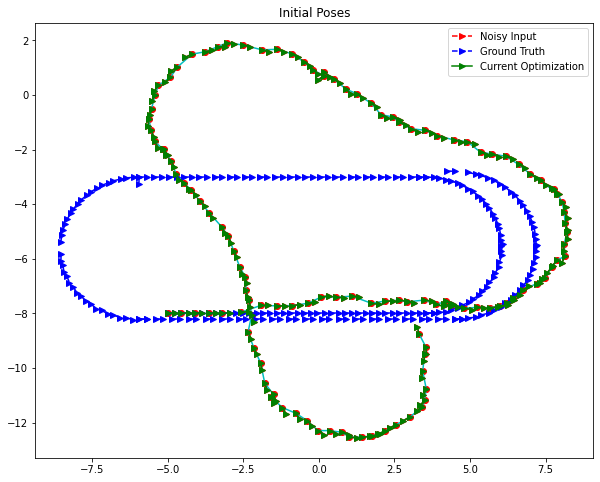

In [4]:
data = Dataset(DATA_PATH+"edges.txt", odom_w = 25, loopc_w = 1000, fixedp_w = 1200)
data.generate_g2o("initial")
data.display("Initial Poses")

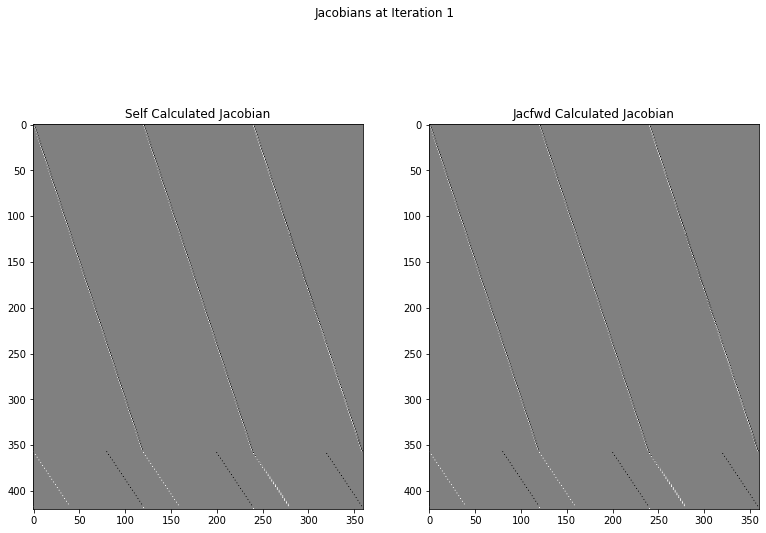

Frobenius norm between Jacobian from jacfwd and Calculated Jacobian is: 0.0
Iteration: 1 | Error: 913388.4
Iteration: 2 | Error: 142920.11
Iteration: 3 | Error: 896.10596
Iteration: 4 | Error: 476.4599
Iteration: 5 | Error: 224.90128


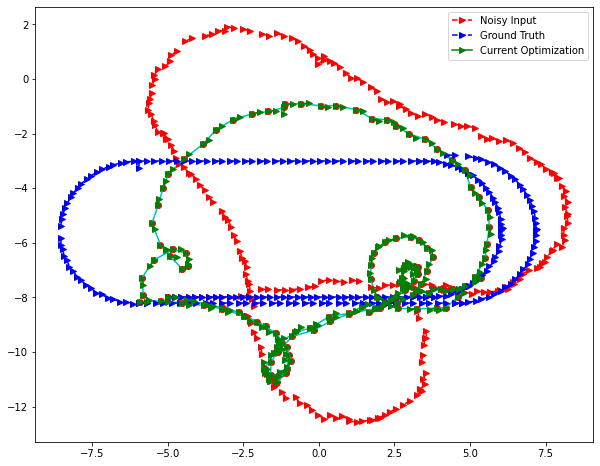

Iteration: 6 | Error: 183.18338
Iteration: 7 | Error: 151.77037
Iteration: 8 | Error: 127.63851
Iteration: 9 | Error: 146.34428
Iteration: 10 | Error: 211.35406


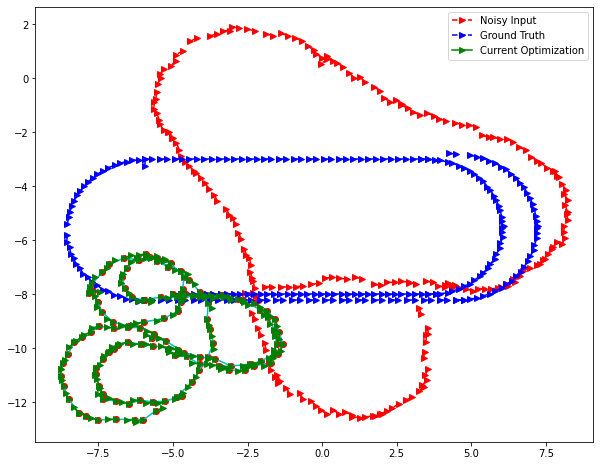

Iteration: 11 | Error: 65.15232
Iteration: 12 | Error: 57.64904
Iteration: 13 | Error: 58.61904
Iteration: 14 | Error: 70.56326
Iteration: 15 | Error: 50.278797


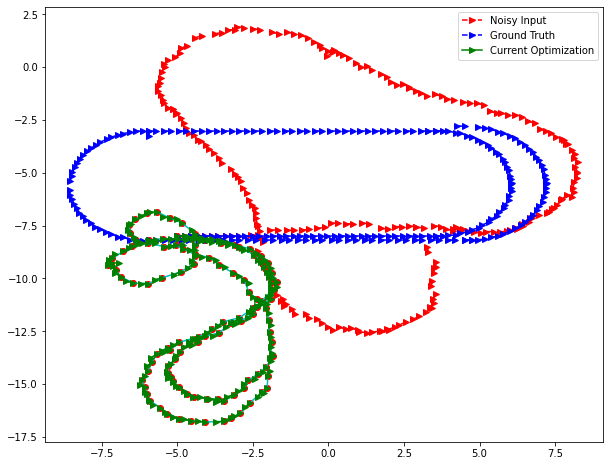

Iteration: 16 | Error: 46.22662
Iteration: 17 | Error: 46.167545
Iteration: 18 | Error: 50.070942
Iteration: 19 | Error: 64.84349
Iteration: 20 | Error: 40.049873


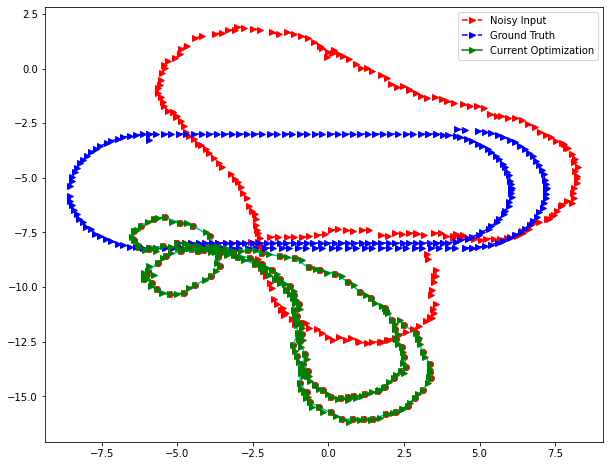

Iteration: 21 | Error: 36.316994
Iteration: 22 | Error: 36.231834
Iteration: 23 | Error: 39.29578
Iteration: 24 | Error: 47.821156
Iteration: 25 | Error: 30.560379


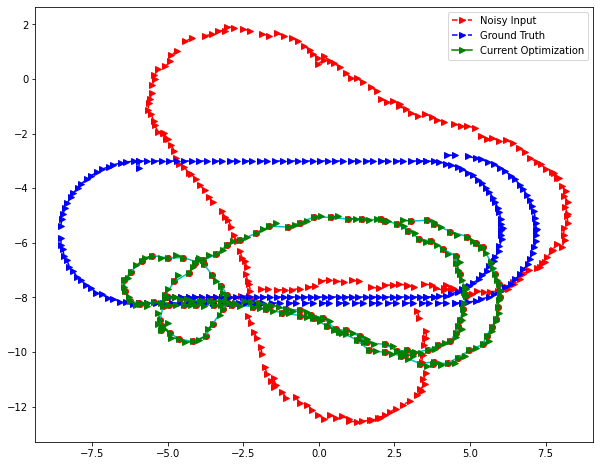

Iteration: 26 | Error: 28.446915
Iteration: 27 | Error: 28.281303
Iteration: 28 | Error: 28.848366
Iteration: 29 | Error: 28.659575
Iteration: 30 | Error: 25.23335


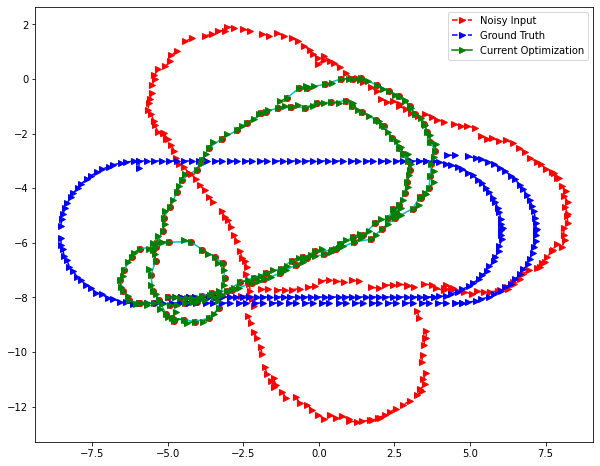

Iteration: 31 | Error: 25.126402
Iteration: 32 | Error: 24.641518
Iteration: 33 | Error: 24.310976
Iteration: 34 | Error: 24.17218
Iteration: 35 | Error: 24.125408


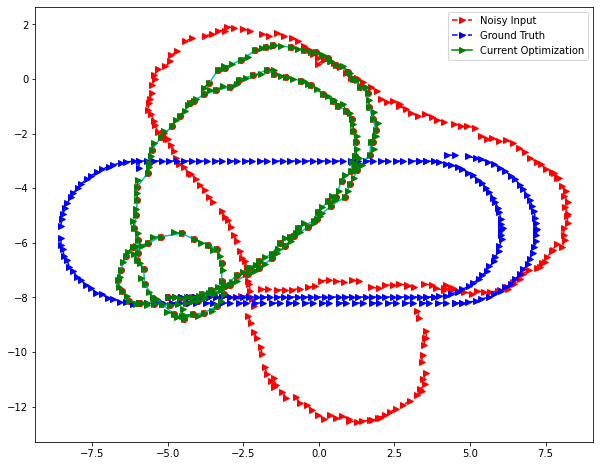

Iteration: 36 | Error: 24.109144
Iteration: 37 | Error: 24.103138
Iteration: 38 | Error: 24.100725
Iteration: 39 | Error: 24.09975
Iteration: 40 | Error: 24.099318


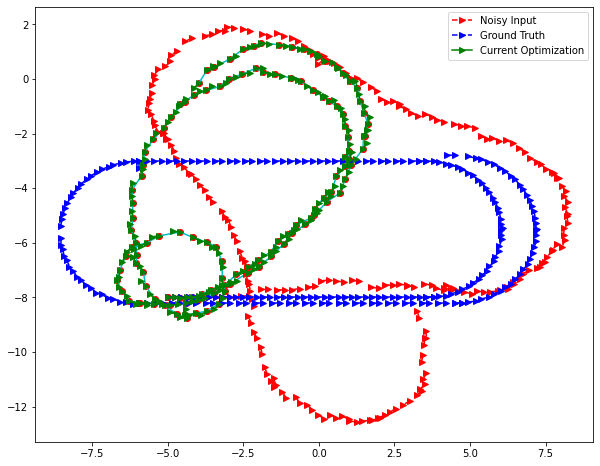

Iteration: 41 | Error: 24.099136
Iteration: 42 | Error: 24.099058
Iteration: 43 | Error: 24.099035
Iteration: 44 | Error: 24.099016
Iteration: 45 | Error: 24.09902


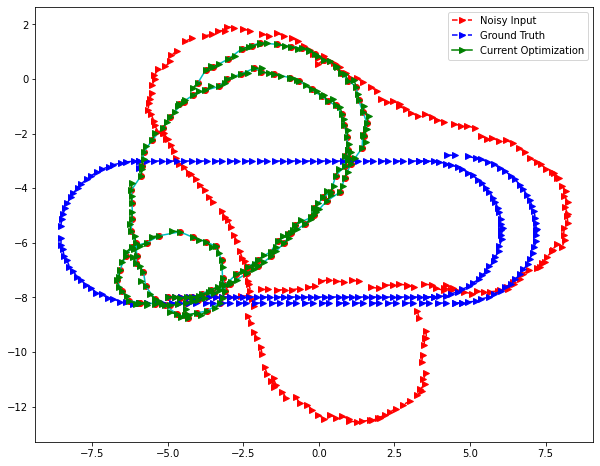

Iteration: 46 | Error: 24.099007
Iteration: 47 | Error: 24.099003
Iteration: 48 | Error: 24.098997
Iteration: 49 | Error: 24.099022
Iteration: 50 | Error: 24.099003


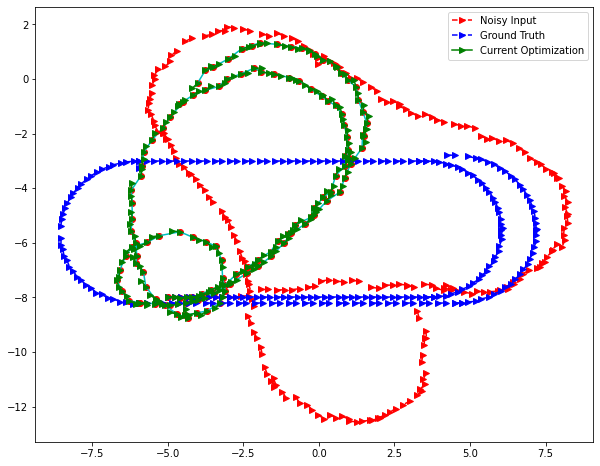

Iteration: 51 | Error: 24.099014
Iteration: 52 | Error: 24.099018
Iteration: 53 | Error: 24.099007
Iteration: 54 | Error: 24.09901
Iteration: 55 | Error: 24.099012


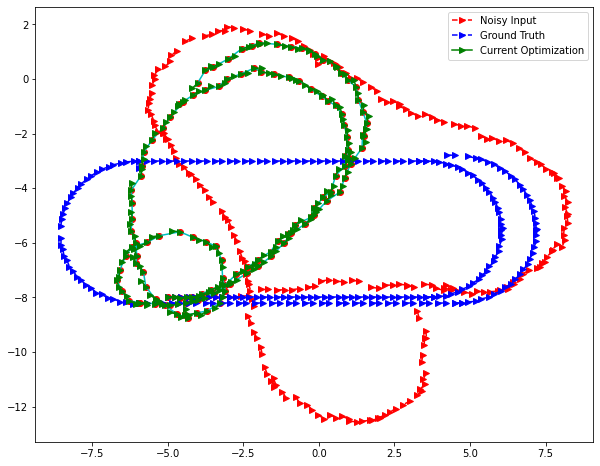

Iteration: 56 | Error: 24.099007
Iteration: 57 | Error: 24.099003
Iteration: 58 | Error: 24.099
Iteration: 59 | Error: 24.099007
Iteration: 60 | Error: 24.099016


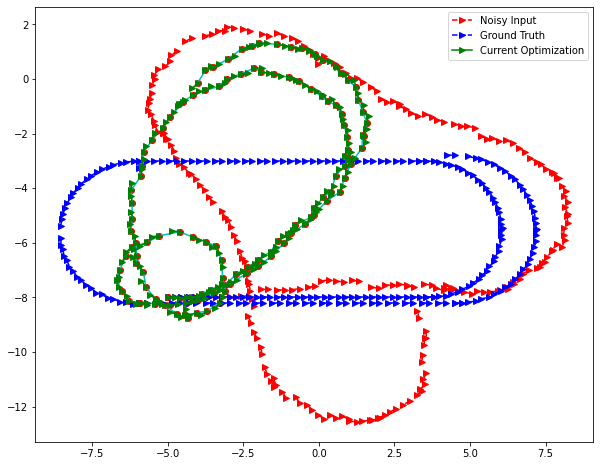

In [5]:
data.levenberg_marquard(1, n_iters=60, verify_jacfwd = False, DEBUG=False)

In [6]:
data.generate_g2o("opt")

G2O file, opt.g2o generated successfully


## 2.1 Answer

Give a detailed answer addressing the above questions. When I run the above code, it should follow points described above (such as plots at every 10 steps) and (When I run the above code, it should) write the optimized poses to a file named `opt.g2o`. As a backup, save another file `opt_backup.g2o` in an offline manner beforehand.

That apart, save important plots and add them here so that it can supplement your answer, for example you could add plots at crucial stages of optimization. You have to add useful metrics/plots from `EVO` (refer to supplementary notebook). Using EVO, the bare minimum you have to report is `mean absolute pose error (ape)` and `mean relative pose error (rpe)`. However, you are encouraged to use tools like `evo_traj` and [more](https://github.com/MichaelGrupp/evo/#command-line-interface) and add more plots/metrics. Marks will be awarded based on overall analysis & presentation which would reflect your understanding.

Note that `EVO` and `g2o_viewer` (below) could help you in debugging.

Add answer for 2.1 here:

# A2.1)

## Introduction
In this question, we have been given the noisy input data on which we perform Pose Graph Optimization to try and get as close as possible to the ground truth trajectory. In our experimentation, we attempted to try and reduce the error as much as possible by changing the values/weights in the information matrix. To faciliate this experimentation, we build the diagonal information matrix as:
\begin{bmatrix}
w_1 & \dots  & 0   & 0   & \dots  & 0  & 0  & 0  & 0\\
\vdots   & \ddots & \vdots   & \vdots   & \dots  & \vdots  & \vdots  & \vdots  & \vdots\\
0   & \dots  & w_1 & 0   & \dots  & 0  & 0  & 0  & 0\\
0   & \dots  & 0   & w_2 & \dots  & 0  & 0  & 0  & 0\\
\vdots   & \vdots  & \vdots   & \vdots   & \ddots & \vdots  & \vdots  & \vdots  & \vdots\\
0   & \dots  & 0   & 0   & \dots  & w_2 & 0  & 0  & 0\\
0   & \dots  & 0   & 0   & \dots  & 0  & w_3 & 0  & 0\\
0   & \dots  & 0   & 0   & \dots  & 0  & 0  & w_3 & 0  \\
0   & \dots  & 0   & 0   & \dots  & 0  & 0  & 0  & w_3  \\
\end{bmatrix}
where, \
$w_1$ is the 'importance weight' given to the odometric constraints,    \
$w_2$ is the 'importance weight' given to the loop closure constraints, \
$w_3$ is the 'importance weight' given to the anchoring constraint(s)

## Residual Calculation
The residual calculation can be divided into three main parts: \
1. **Odometric Constraints** \
    The odometric constraint minimization term is given by: 
    $$ x_{k} + u_{x, (k,k+1)} - x_{k+1} $$ 
    $$ y_{k} + u_{y, (k,k+1)} - y_{k+1} $$
    $$ \theta_{k} + u_{\theta, (k,k+1)} - \theta_{k+1} $$ 

2. **Loop Closure Constraints** \
    The loop closure constraint minimization term is similar, however it is between any two vertices of the graph, and not necessarily adjacent ones. The minimization term considering a loop closure relation between vertex 'a' and vertex 'b' is given by: 
    $$ x_{a} + u_{x, (a,b)} - x_{b} $$ 
    $$ y_{a} + u_{y, (a,b)} - y_{b} $$
    $$ \theta_{a} + u_{\theta, (a,b)} - \theta_{b} $$ 

3. **Anchor Constraint(s)** \
    This constraint is used when we know that a particular vertex must be at a given point in space and the minimization term is: 
    $$ x_{A}  - X_A $$ 
    $$ y_{A}  - Y_A $$
    $$ \theta_{A}  - \Theta_A $$
    
On combining the three, we get our residual as:

$$ f = \begin{bmatrix}
x_{k} + u_{x, (k,k+1)} - x_{k+1} \\
y_{k} + u_{y, (k,k+1)} - y_{k+1} \\
\theta_{k} + u_{\theta, (k,k+1)} - \theta_{k+1} \\ 
\vdots_{3(n_p-1)} \\
\hline \\
x_{a} + u_{x, (a,b)} - x_{b} \\
y_{a} + u_{y, (a,b)} - y_{b} \\
\theta_{a} + u_{\theta, (a,b)} - \theta_{b} \\
\vdots_{3n_{lc}} \\
\hline \\
x_{A}  - X_A \\
y_{A}  - Y_A \\ 
\theta_{A}  - \Theta_A \\
\end{bmatrix}_{(3(n_p + n_{lc}), 3n_p)} $$
where,  
$n_p$ = Number of vertices, \
$n_{lc}$ = Number of loop closure constraints, \
$u_{(a,b)}$ describes the motion from $X_a$ to $X_b$

## Jacobian

### Calculation
If we consider the residual to be of the form:
$$ f = \begin{bmatrix}
F_1 \\
F_2 \\
F_3 \\
\vdots \\
F_{3m - 1} \\
F_{3m}
\end{bmatrix},$$
then the jacobian is of the form:
$$J = \begin{bmatrix}
\frac{\partial F_1}{\partial x_1} & \dots & \frac{\partial F_1}{\partial x_{n_p}} & \frac{\partial F_1}{\partial y_1} & \dots & \frac{\partial F_1}{\partial y_{n_p}} & \frac{\partial F_1}{\partial \theta_1} & \dots & \frac{\partial F_1}{\partial \theta_{n_p}} \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
\frac{\partial F_{3m}}{\partial x_1} & \dots & \frac{\partial F_{3m}}{\partial x_{n_p}} & \frac{\partial F_{3m}}{\partial y_1} & \dots & \frac{\partial F_{3m}}{\partial y_{n_p}} & \frac{\partial F_{3m}}{\partial \theta_1} & \dots & \frac{\partial F_{3m}}{\partial \theta_{n_p}} \\
\end{bmatrix}_{(3(n_p + n_{lc}), 3n_p)}$$
where, 
$m = n_p + n_{lc}$

Note: Although $\theta$ cannot be optimized using Euclidean methods, for simplicity purposes, we are assuming it can be done that way.

### Verification
For verifying that the Jacobian calculated is correct, we use the `jax` function `jacfwd`. \
**Note**: `jacfwd` is preferred for **tall** Jacobians, while the `jacrev` function is preferred for **wide** Jacobians.

To perform verification, the `verify_jacfwd` flag can be set to `True` in the above written function. This will calculate the Frobenius norm between the Jacobians calculated using `jacfwd` and the function written, for the first 5 iterations. We can see that value of the norm is **0.0**. Hence the function written for calculating the Jacobian is verfied to be correct.

Below is a visual depiction of the Jacobian matrices.

![Jacobian Comparison](misc/images/jacobian-comparison.png)

## Optimization
After experimenting with various values, we were able to achieve optimize the pose graph to an error value of **24.099**, using $w_1 = 25, w_2 = 1000, w_3 = 1200$. 

On viewing the intermediate outputs during optimization, we notice that at some iterations, the partially optimized trajectory closely resembles the ground truth. However our algorithm **does not converge at this point**, since the data that we use for pose graph optimization is the noisy data that we receive from the sensors, and not the ground truth itself.

![Iteration 25](misc/images/iteration-25.png)

In the optimization, we attempt to find a balance between the odometry constraints, the loop closure constraints and the anchor constraint(s). We can only attempt to make an educated guess on which of these constraints is more important based on what we know about the sensors. Noise however, will affect the readings and thus we will not get the perfect ground truth trajectory on optimization, although we can expect to get a shape that reasonably resembles it.

![Converged Optimization](misc/images/optimized-output.png)

On viewing optimized trajectory that we get after pose graph optimization, we can see that while it is not the same as the ground truth trajectory, the shape of the trajectory does resemble that of the ground truth. We can see that the shape is oval as expected and the end of the trajectory meets the earlier part of the trajectory in a very similar way to that in the ground truth trajectory. The key difference that we notice is the difference in position scaling and the rotated nature of the pose graph optimized trajectory.

## Optimized Trajectory Analysis using G2O/EVO

### G2O Viewer

![G2O View of Optimized Trajectory](misc/images/g2o_view_opt.png)

### EVO

* `RPE`

![EVO RPE Comparison](misc/images/EVO_rpe_opt.png)

```
--------------------------------------------------------------------------------
RPE w.r.t. translation part (m)
for delta = 1 (frames) using consecutive pairs
(not aligned)

       max	0.286999
      mean	0.117228
    median	0.113960
       min	0.005671
      rmse	0.132089
       sse	2.076267
       std	0.060870

--------------------------------------------------------------------------------
```

* `APE`

![EVO APE Comparison](misc/images/EVO_ape_opt.png)
```
--------------------------------------------------------------------------------
APE w.r.t. translation part (m)
(not aligned)

       max	10.232110
      mean	5.311355
    median	5.655153
       min	0.000000
      rmse	6.183810
       sse	4588.740437
       std	3.166862

--------------------------------------------------------------------------------
```
* `TRAJ`

![EVO TRAJ Comparison](misc/images/EVO_traj_opt.png)
```
--------------------------------------------------------------------------------
name:	gt
infos:
	nr. of poses	120
	path length (m)	52.976517997999295
	pos_end (m)	[-2.8 -4.5  0. ]
	pos_start (m)	[-8.  5.  0.]
--------------------------------------------------------------------------------
name:	opt_temp
infos:
	nr. of poses	120
	path length (m)	53.76199117898577
	pos_end (m)	[-0.15363269  4.0147176   0.        ]
	pos_start (m)	[-8.  5.  0.]
```

## Other Experimentation with Optimization

### Experimenting with Information Matrix Weights 

#### $w_1$ = 10, $w_2$ = 1000, $w_3$ = 1000 : Lower Cost using a Large Difference in Order of Information Matrix Weights
![Info Matrix: 10, 1000, 1000](misc/images/10-1000-1000_g2o_viewer.png)

#### $w_1$ = 100, $w_2$ = 1000, $w_3$ = 1200 : Slightly Higher Odometric Weight
![Info Matrix: 10, 1000, 1000](misc/images/100-1000-1200_g2o_viewer.png)

#### $w_1$ = 500, $w_2$ = 700, $w_3$ = 1000 : Initialization Recommended in the Notebook
![Info Matrix: 10, 1000, 1000](misc/images/500-700-1000_g2o_viewer.png)

## 2.2 Using g2o's optimization: g2o binary or g2o viewer 

Installation setup is described in supplementary notebook. More details for 2.2.1 and 2.2.2 can be found in the supplementary notebook.

### 2.2.1 Optimizing `edges.txt`
First task is to optimize the poses of dataset you've been working with so far.

### 2.2.2 Optimizing `intel` and `sphere` datasets
You have been given two datasets in the `data` folder. You have to use `g2o_viewer` to optimize these both. You have to experiment with the options/parameters available in the GUI. More instructions in supplementary notebook. You have to experiment till you get the trajectories which look like the following:

<table><tr>
<td> <img src="./misc/intel.jpg" alt="Drawing" style="width: 250px;"/> </td>
<td> <img src="./misc/sphere.jpg" alt="Drawing" style="width: 250px;"/> </td>
</tr></table>

## 2.2 Answer

Add images: take screenshot of the GUI of `g2o_viewer` after optimization for all 3 [[CP-M]] and add here. Briefly describe what you had to do (detailed answer is not expected). g2o could potentially give you close to ground truth trajectory for all 3, but if you are unable to get to close to ground truth, add the best you can get.

<table
<tr>
    <td colspan="2"> <img src="./misc/images/traj_g2o_opt.png" alt="Drawing" style="width: 1000px;"/> </td>
</tr>
<tr>
<td> <img src="./misc/images/intel_g2o_opt.png" alt="Drawing" style="width: 500px;"/> </td>
<td> <img src="./misc/images/sphere_g2o_opt.png" alt="Drawing" style="width: 500px;"/> </td>
</tr></table>

### What We Did

We produce the images for intel and edges.txt after 100 iterations of gauss newton, initialized by spanning tree. For sphere, we use around ~300 iterations due to imperfections on the sphere.

### Experiments

*We consider error to be the output of chi2 - derived from Mahalanobis distance. Further, these experiments were all done on edges.txt, unless specified otherwise* 

**Impact of Initial Guess**: We see comparable performance of spanning tree and odometry initialization for the given dataset. It is interesting to see the different approaches to these initializations. We notice that Spanning Tree forms a guess close to ground truth, while odometry readings produce high errors while still resembling the ground truth to an extent. 

![Easter Egg](./misc/images/span_odo_edges.png)

**Choice of optimizer**: We did not see significant differences between the options for gauss newton and Levenberg Marquadt. Even the variations of these algorithms produced similar results. However, using 2dlinear provides instant results (~2 iterations), converging with error similar to that of GN/LM. This is likely because that optimizer is built for 2D pose-graph SLAM such as this (as per [g20 documentation](http://g2o.xuezhisd.top/classg2o_1_1SolverSLAM2DLinear.html#details)). 2dlinear also performed well on the intel dataset.

**To Kernalise or Not To Kernalise**: We also experiment with the robust kernel option provided in g2o. Here, we observe significantly better performance than the previous approached; in some cases, with lower error in fewer iterations. The best results were obtained with the Huber and pseudo-huber kernel. Some other kernels also produced low errors (even close to 0), but differed from ground truth. We suspect that this is because the kernels chose incorrect edges to weigh more. However, we may have missed some parameter required to tune that specific kernel.

Using the Huber kernel also produced a better sphere than previous methods (pictured below). It also required far fewer iterations than before to converge / resemble ground truth.

![ANOTHER EASTER EGG WHAT](./misc/images/huber_sphere.png)

###  * Important Information regarding Questions 3  & 4
Note that it is mandatory to attempt EITHER 3 OR 4, only one of it. If you attempt both, the question which you score more will be considered and the other as bonus question. 

It is encouraged for those into robotics/deep learning research to prefer 4 over 3.

# [Bonus*] 3. Deriving Motion model geometrically
\* -> read information above under section "Important Information regarding Questions 3  & 4"

 
The current robot state is as follows: ($i$ and $k$ are interchangably used below, sorry I am too lazy to edit now 😛)  
![robot-situation.png](./misc/robot-situation.png)

Can you derive the below equation using geometry? (Read on)

$$x_{k+1} = x_{k} + \Delta x_{(k,k+1)} \cos(\theta_k) - \Delta y_{(k,k+1)} \sin(\theta_k) \\
y_{k+1} = y_{k} + \Delta y_{(k,k+1)} \cos(\theta_k) + \Delta x_{(k,k+1)} \sin(\theta_k) \\
\theta_{k+1} = \theta_{k}+  \Delta \theta_{(k,k+1)} \tag{3}$$

In other words, we want to find $\delta$'s in terms of $\Delta$'s
$$\delta x = \Delta x \cos(\theta) - \Delta y \sin(\theta) \\
\delta y = \Delta y \cos(\theta) + \Delta x \sin(\theta) \tag{2}$$

where $\delta$'s are the updates in our motion model equation:
$$ x_{k+1} = x_{k} + \delta x \\
y_{k + 1} = y_k + \delta y \\
\theta_{k+1} = \theta_{k} + \delta \theta \tag{1}$$

Oh yes, $\theta$ is straightforward, i.e. $\delta \theta = \Delta \theta$ but why? 

Using geometry, you could just draw and insert a self-explanatory image as the answer to this question.

If you can derive it without using geometry purely using transform matrices/algebra, that is fine too. Whatever you're comfortable.

## 3. Answer

![Q3 Geometry Illustration](misc/images/q3_image.jpeg)

In the above diagram, we consider two robot poses, ${}^P(x_i,y_i)$ and ${}^P(x_{i+1},y_{i+1})$, where the frame $P$ is defined by the coordinate axes $XY$ and frame Q is defined by the coordinate axes $X_i^{'}Y_i^{'}$. We use the standard notation used in class where ${}^PX$ is the representation of X as seen in frame P.

Our task is to determine ${}^P(x_{i+1},y_{i+1})$ given  ${}^P(x_i,y_i)$, ${}^P\theta_i$, ${}^Q\Delta x_{(i,i+1)}$, ${}^Q\Delta y_{(i,i+1)}$ and ${}^Q\Delta \theta_{(i,i+1)}$

We can clearly see that ${}^Q(x_{i+1},y_{i+1})$ is simply $(\Delta x, \Delta y)$.

Now given ${}^Q(x_{i+1},y_{i+1})$, we need to find ${}^P(x_{i+1},y_{i+1})$, which we can do with the following equation:
$$ {}^P(x_{i+1},y_{i+1}) = T_Q^P*{}^Q(x_{i+1},y_{i+1}) $$
where, $T_Q^P$ is the transformation matrix from frame $Q$ to frame $P$

## Determining $T_Q^P$
### Translation
From the figure, we see that 
$$t_Q^P = 
\begin{bmatrix} 
x_i \\ 
y_i 
\end{bmatrix}$$

### Rotation
We can also see that the frame $Q$ is rotated by an angle of $\theta_i$ with respect to frame $P$, thus,
$$ R_Q^P = R_{\theta} = 
\begin{bmatrix}
\cos{\theta} & -\sin{\theta} \\
\sin{\theta} &  \cos{\theta}
\end{bmatrix}$$

### Combining
On combining the translation and rotation parts, we get:
$$ T_Q^P = \begin{bmatrix}
{R_Q^P}_{2x2} & {t_Q^P}_{2x1} \\
0_{1x2} & 1_{1x1}
\end{bmatrix}$$

$$\therefore T_Q^P = \begin{bmatrix}
\cos{\theta} & -\sin{\theta} & x_i \\
\sin{\theta} &  \cos{\theta} & y_i \\
0 & 0 & 1
\end{bmatrix}$$

Thus, we get
$$
\begin{bmatrix}
{}^Px_{i+1} \\
{}^Py_{i+1} \\
1 
\end{bmatrix} = \begin{bmatrix}
\cos{\theta} & -\sin{\theta} & x_i \\
\sin{\theta} &  \cos{\theta} & y_i \\
0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
\Delta x_i \\
\Delta y_i \\
1 
\end{bmatrix}$$

On expanding, 
$$
\begin{bmatrix}
{}^Px_{i+1} \\
{}^Py_{i+1} \\
1 
\end{bmatrix} = \begin{bmatrix}
x_i + \Delta x_i\cos{\theta_i} - \Delta y_i\sin{\theta_i} \\
y_i + \Delta x_i\sin{\theta_i} + \Delta y_i\cos{\theta_i} \\
1 
\end{bmatrix}$$

### Calculating $\theta_{i+1}$

We can see that with respect to frame $Q$, the pose at $(x_{i+1},y_{i+1})$ is at an angle of $\Delta\theta_{(i,i+1)}$, and the frame $Q$ itself is at an angle of $\theta_i$ with respect to frame $P$. So the total rotation for pose $(x_{i+1},y_{i+1})$ with respect to frame $P$ will be $\theta_i + \Delta\theta_{(i,i+1)}$, by simple addition as we can see in the diagram. What is important to note is that we are not looking to find the angle by which the origin of the coordinate system $X_{i+1}^{''}Y_{i+1}^{''}$ would have to be rotated, which would intuitively also simply be $\theta_i + \Delta\theta_{(i,i+1)}$. It can formally be verified by extending the line joining pose $(x_{i+1},y_{i+1})$ and $(x_{i},y_{i})$, and then using the Exterior Angle Property. Confusion may arise as to why the $\theta$ update is correct if we do not realize that the rotation is not done using the origin of frame $P$ as pivot.

Thus, we can conclude that:
$$x_{i+1} = x_{i} + \Delta x_{(i,i+1)} \cos(\theta_i) - \Delta y_{(i,i+1)} \sin(\theta_i) \\
y_{i+1} = y_{i} + \Delta y_{(i,i+1)} \cos(\theta_i) + \Delta x_{(i,i+1)} \sin(\theta_i) \\
\theta_{i+1} = \theta_{i}+  \Delta \theta_{(i,i+1)}$$

We also know that:
$$ x_{i+1} = x_{i} + \delta x \\
y_{i+1} = y_i + \delta y \\
\theta_{i+1} = \theta_{i} + \delta\theta$$

Hence, in general we can say:
$$\delta x = \Delta x \cos(\theta) - \Delta y \sin(\theta) \\
\delta y = \Delta y \cos(\theta) + \Delta x \sin(\theta) \\
\delta \theta = \Delta \theta $$


# [Bonus*] 4. Research Paper Reading
\* -> read information above under section "Important Information regarding Questions 3  & 4"

(Do not get intimidated, you are not expected to do a thorough research analysis for this task. A high level understanding is sufficient.)


["Past, Present & Future of SLAM: Towards the Robust Perception Age"](https://arxiv.org/abs/1606.05830) is an exciting survey paper of 2016 which sums up, well, the "past, present & future" of SLAM. Your task is as follows:

1. Go through the sections "IV. LONG-TERM AUTONOMY II: SCALABILITY" & "III. LONG-TERM AUTONOMY I: ROBUSTNESS". Don't worry, you are not expected to have a deep understanding. Skip the parts which you don't understand at all. Go through it at a high level, and take a slightly closer look at "Open Problems" in these sections.

2. Read up common applications of deep learning for computer vision/robotics through blogs online (for example, first 4 points of [this](https://machinelearningmastery.com/applications-of-deep-learning-for-computer-vision/). Again, you are only expected to understand it at a high level, for example, 'semantic segmentation is an application of deep learning for computer vision which is the task of assigning a category to each of the pixels in the image'.

Firstly, summarize your understanding of the above two points.
   
Now, from the understanding you've gathered so far, how would you approach solving those "Open Problems"? 
Can these algorithms help in dealing with some of the issues you might have faced during this project? Can the deep learing based high level understanding of the world help in SLAM? In the context of long term autonomy, imagine tomorrow's world with a buddy robot R2-D2 which follows you wherever you go... Now imagine how easily the trajectory can diverge, how big the map could soon become and how the computation could easily become intractable.   

Answer the above questions in the context of this project and those 2 sections of the survey paper.

## 4. Answer

An end-to-end solution to SLAM is highly sought after for a multitude of applications. Still, it is challenging to achieve because of factors that tie into its universality and quality. The review paper “Past, Present & Future of SLAM” <a href="#1">[1]</a> concisely describes the problems of universality - how we can scale SLAM systems and quality - how we can make it robust. This report will first summarise the problems in these two facets, group the open problems in those topics and then discuss the deep learning approaches to these. While mentioning the deep learning solutions, we also attempt to contextualise it in the scope of this project.

# Problems

## Robustness

Robustness in SLAM constitutes consistency and accuracy in the end-to-end solution. Software failure (algorithmic) as well as hardware failure (sensor degradation), for instance, can hamper this goal.

Algorithmic failure refers to problems in one of the two components of SLAM - the frontend and backend. Erroneous inputs are often fed to the backend from the frontend, including incorrect loop closures. These false loop closures and outliers can disproportionately affect the MAP estimate. Hence, SLAM suffers from not only being a non-convex and often intractable problem, but also a problem that requires high precision input. For convenience, we consider these problems in three phases: perception, association and validation.

- Perception: In this context, we refer to perception as the task of receiving sensory information and encoding it appropriately. It is evident that using images for tasks such as feature matching is expensive, making “bag of words” approaches attractive. A bulk of SLAM relies on loop closure, which is a long term association. This encoding is critical when we look at the next phase - association.


Association: As seen in ICP, it is critical to associate points captured from our sensors across multiple views. Data association has been extensively researched but till remains debated, especially in feature-based algorithms. One such instance is in perceptual aliasing, where multiple locations are considered to be the same. This common signature for distinct physical entities can trick approaches like Bag of Words as well. There is a question of efficiency nested here as well, as we must have rich encodings while simultaneously avoiding expensive brute-force comparisons to find loop closures.

    Robustness in the real world also requires modelling the dynamic agents that inhabit it, breaking the rigid shape assumption of several algorithms. Current SLAM systems suffer in a dynamic environment as moving agents do not necessarily belong to the map, making data association and loop closure difficult. Here too, the SLAM algorithm is tasked with *perceiving*  these dynamic agents and then *associating* them across frames, or ignoring them altogether.


- Validation: We refer to the task of discarding erroneous sensory input and assigning  confidence to our self-defined loop closures as validation here.  Fail-safe SLAM requires highly accurate estimates. Algorithms like RANSAC are popular for rejecting outliers and can help in verifying the pose graph edges. Still, solutions that are fool-proof and failure-aware are to be explored.

Hardware failure is expected in deployed applications, necessitating robustness to natural degradation within the SLAM algorithm. Here too, detecting failure early on is critical. This could include the detection of sensor malfunctions, and noise statistics that the SLAM algorithm requires. Further, we must consider the difficulty of conflicting sensor fusion, as well as complex environments such as underwater where sensors and algorithms may not perform as well.

## Scalability

Scalability in SLAM constitutes modelling the entire area traversed while accounting for computational and memory constraints. This may not be a concern with smaller regions like a house, but large scale applications require a scalable solution. Since SLAM is often used on moving agents, there is a very low bound on the memory and processing power of the system. Naturally, there are two approaches to solve this: reduce the information stored - sparsification, and use more computing power - systems solutions.

Sparsification methods prune the pose graph, using information theory to ensure that new nodes add to the map, and aren’t a consequence of mapping duration. Other approaches use alternate functions to represent the trajectory or approximate the trajectory. With sparsification, we are continuously deciding what information to use.

Here, hardware can help SLAM by leveraging the power of multiple processors and threads to perform calculations. Alternatively, the factor graph can be divided into sub-maps, with a tree-like structure. In essence, data representations are essential for SLAM, and some forms can leverage the power of parallel computing. On a similar thread, robots can form a cluster that maps a region while performing computations as a distributed system. This comes with its own problems of communication between robots and synchronizing a correct map.

# Possible Approaches


## SLAM in Dynamic Environments

Intuitively, SLAM should not be affected by dynamic agents if we can ignore/detect the dynamic regions. Semantic segmentation can assist here by reducing the distinguishing between static and dynamic objects, thereby reducing the importance of dynamic objects, improving the pose estimates. One such approach <a href="#2">[2]</a><a href="#3">[3]</a> considers dynamic objects as outliers entirely, removing them from the feature map.

## Failure in SLAM

As mentioned earlier, robust SLAM algorithms are difficult to achieve across all environments. Hence, as in the case of autonomous cars that make active use of SLAM, diagnosing SLAM failure is critical. Reinforcement Learning has helped here as failure can propagate across states, making it easier to filter actions <a href="#4">[4]</a> (Prof Madhav’s work!). The agent can hence generate new actions to compensate for erroneous information.

Considering that SLAM involves predicting pose, we hypothesize that adversarial regularization can assist in deep learning SLAM formulations. Since the former is a generative task, we can consider a discriminator that determines if the prediction is valid or not. Some research <a href="#5">[5]</a> has shown promise with this method, as adversarial learning can provide sharper and more accurate pose estimates.

## Feature Matching

Feature matching is likely the most straightforward application of deep learning thus far. Modern mega networks such as ResNets and VGG Net can be considered as feature encoders, producing encodings for image inputs. As a result, we can use these new features to compare images.

Feature matching is a critical task for SLAM frontend that is difficult for certain environmental conditions, even for deep learning methods. For instance, some approaches mention later such as SFMlearner assume Lambertian surfaces to avoid lighting fluctuations. But, recent advances show progress here.

Moreover, humans tend to associate features with regions, leveraging spatial information and associating features with one another. Hence, graph neural networks seem like a natural form for feature matching. SuperGlue <a href="#6">[6]</a>, for instance, considers individual “visual descriptors” as nodes and enables cross image mapping. The result is more accurate feature mapping than conventional methods.

## Image-Based Pose Estimation

In recent years, there have been several approaches to estimating ego-motion from monocular images or video sequences. One common approach for pose estimation involves using a series of frames and estimating the transformations between them, projecting back to a common frame, and using a loss from this reprojection error. Notably, even unsupervised algorithms <a href="#7">[7]</a> of this variety perform comparably to classical SOTA approaches such as ORB-SLAM. Convolutional layers are able to discern depth from these images in an unsupervised manner remarkably, reducing the need for high-cost LiDAR sensors. These flow networks <a href="#8">[8]</a> also perform well in areas where monocular SLAM does not, such as low-texture regions and do a better job at estimating scale from images.

Overall, learning-based methods are able to be robust in their estimates without requiring extensive graph-based computations. As *insert paper* describes, deep learning methods can use just images to output poses, unlike a conventional SLAM pipeline which uses feature extraction, matching, outlier rejection, and motion estimation followed by optimizations (such as Bundle Adjustment). Further, deep learning helps circumvent the intractable calculations with SLAM.

## Hardware Failure Detection

Hardware failure detection uses deep learning extensively in the industry currently. As recent research indicates <a href="#9">[9]</a>, simple deep learning methods such as SVM and neural networks can produce highly accurate predictions. Since the heart of hardware failure detection is looking for outliers or stray outputs, we can even consider this as a classification task. It is safe to assume that the environment has similar enough traits to use sensor measurements as input considering the similarities within KITTI, and even Cityscape.

One possible approach to this is by using random forest, which forms a series of decision trees and chooses the most common verdict from these trees. The input to these trees could be the sensor outputs and the outputs, the probability of anomalous behaviour.

## Distributed Computing

Most research today in distributed computing is motivated by deep learning. Since the parameters of complex networks are often orders of magnitude larger than SLAM formulations, several strides have been made to accommodate even trillion parameter networks. A combination of parallelism and memory optimizations, like in DeepSpeed, can produce great results. It goes without saying that these must leverage the GPU due to its inherent parallelism. Since SLAM also relies on matrix multiplications, and iterative optimization algorithms, it too can leverage this power. The jax library used in this project is an example of this, optimized for GPU, in the same vein as PyTorch. In review, SLAM can deeply benefit from 1) a good system architecture and 2) software that can take advantage of the hardware (such as prefetching poses from the disk before using it).

This is possibly where our project could’ve beneffited the most. We noticed that the jax library took very long to compute jacobians since it relied on the CPU. Perhaps, with better hardware and systems optimizations, we could multithread and parallelize our code.

## Cloud Computing

SLAM is extremely popular these days in Augmented Reality. AR devices are naturally small but have to perform extensive localisation to understand the world. This domain is one of the best indicators of where industrial SLAM is heading - the cloud. Expensive computations can take place on dedicated GPU servers with the user devices serving as sensory organs in a bigger system. While 5G advances may help significantly, we imagine that running point registration locally will remain important but that the problems with large maps and complex environments can be solved using the cloud. We also imagine that cloud and on-device processing can occur together, rather than being disjoint entities. Hence, just as in distributed computing, clever distribution of work should yield performance boosts. The lack of storage constraints in the cloud should also alleviate problems in long-term mapping.

# Artoo

For the purposes of this project, we will assume that R2-D2 is sentient and can path-plan on its own. Further, we assume that humans are smart enough to not push R2-D2 into a lake amid dystopian world fears.

When attempting to answer the intractability of large scale mapping and localization, we first think of the AR cloud. The AR cloud is a representation of the real world stored in the cloud, with a real world mapping. In the AR context, we can place 3d figues onto this cloud and see the figures through our devices at the corresponding locations. Similarly, we imagine that future systems will not attempt to store entire maps on the device, rather deferring that to the cloud. As the review paper alluded to, storing submaps of the world will suffice in most cases with the larger map an API call away. Hence, course corrections and loop closures within the submap will be relevant.

Current AR research heavily employs deep learning, as it circumvents the pose graph construction largely, while using simpler stereo constraints, epipolar geometry and such. Hence,  deep learning models are likely going to complement the shift to the cloud greatly, as we can achieve comparable performance without computational worry (apart from the forward pass required that is).

<a href="#1" id="1">[1]</a> Cadena, C., Carlone, L., Carrillo, H., Latif, Y., Scaramuzza, D., Neira, J., Reid, I. and Leonard< , J., 2020. Past, Present, And Future Of Simultaneous Localization And Mapping: Toward The Robust-Perception Age.

<a href="#2" id="2">[2]</a> Yu, C., Liu, Z., Liu, X., Xie, F., Yang, Y., Wei, Q. and Fei, Q., 2020. DS-SLAM: A Semantic Visual SLAM Towards Dynamic Environments.

<a href="#3" id="3">[3]</a> Han, S. and Xi, Z., 2020. Dynamic Scene Semantics SLAM Based On Semantic Segmentation.

<a href="#4" id="4">[4]</a> Prasad, Vignesh, Karmesh Yadav, Rohitashva Singh Saurabh, Swapnil Daga, Nahas Pareekutty, K. Madhava Krishna, Balaraman Ravindran, and Brojeshwar Bhowmick. 2020. Learning To Prevent Monocular SLAM Failure Using Reinforcement Learning.

<a href="#5" id="5">[5]</a> Li, Shunkai, Xue, Fei, Wang, Xin, Yan, Zike, Zha, Hongbin. 2019. Sequential Adversarial Learning for Self-Supervised Deep Visual Odometry.

<a href="#6" id="6">[6]</a> Sarlin, Paul-Edouard, Daniel DeTone, Tomasz Malisiewicz, and Andrew Rabinovich. 2020. Superglue: Learning Feature Matching With Graph Neural Networks.

<a href="#7" id="7">[7]</a> Tinghui Zhou, Matthew Brown, Noah Snavely, David Lowe. 2017. Unsupervised Learning of Depth and Ego-Motion from Video

<a href="#8" id="8">[8]</a> Tateno, Keisuke, Federico Tombari, Iro Laina, and Nassir Navab. 2020. CNN-SLAM: Real-Time Dense Monocular SLAM With Learned Depth Prediction.

<a href="#9" id="9">[9]</a> Turnbull, Doug, Alldrin, Neil. Failure Prediction in Hardware Systems.

<a href="#10" id="10">[10]</a> "Microsoft/Deepspeed. 2020


### Fun section
Check the end of your Project-1 homepage on Notion. :)